In [36]:
import numpy as np
import os
from os.path import isfile
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical

import tensorflow as tf

from tensorflow.keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

### Load training and Validation arrays

In [5]:
dict_genres = {'Electronic':0, 'Experimental':1, 'Folk':2, 'Hip-Hop':3, 
               'Instrumental':4,'International':5, 'Pop' :6, 'Rock': 7  }


reverse_map = {v: k for k, v in dict_genres.items()}
print(reverse_map)

{0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}


In [6]:
npzfile = np.load('shuffled_train.npz')
print(npzfile.files)
X_train = npzfile['arr_0']
y_train = npzfile['arr_1']
print(X_train.shape, y_train.shape)

['arr_0', 'arr_1']
(6394, 640, 128) (6394,)


In [7]:
npzfile = np.load('shuffled_valid.npz')
print(npzfile.files)
X_valid = npzfile['arr_0']
y_valid = npzfile['arr_1']
print(X_valid.shape, y_valid.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


### Check by plotting a Spectogram

Electronic


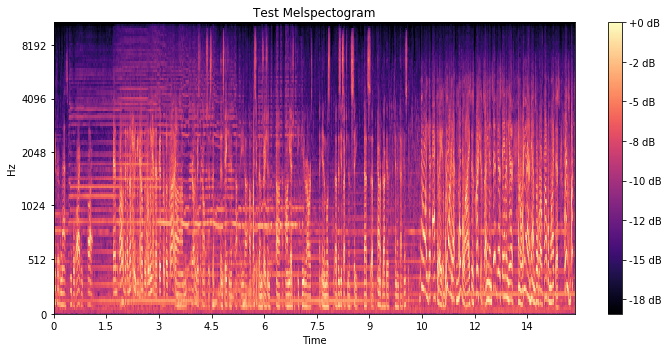

In [6]:
num = 5300
spectogram = X_train[num]
genre = np.argmax(y_train[num])
print(reverse_map[genre])
plt.figure(figsize=(10, 5))
librosa.display.specshow(spectogram.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

### CNN - RNN Model

In [8]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [9]:
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_regularization = 0.001

def conv_recurrent_model_build(model_input):
    print('Building model...')
    layer = model_input
    
    ### 3 1D Convolution Layers
    for i in range(N_LAYERS):
        # give name to the layers
        layer = Conv1D(
                filters=CONV_FILTER_COUNT,
                kernel_size=FILTER_LENGTH,
                kernel_regularizer=regularizers.l2(L2_regularization),  # Tried 0.001
                activation = "relu",
                name='convolution_' + str(i + 1)
            )(layer)
        layer = BatchNormalization(momentum=0.9)(layer)
        layer = MaxPooling1D(2)(layer)
        layer = Dropout(0.4)(layer)
    
    ## LSTM Layer
    layer = LSTM(LSTM_COUNT, return_sequences=False)(layer)
    layer = Dropout(0.4)(layer)
    
    ## Dense Layer
    layer = Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization), name='dense1')(layer)
    layer = Dropout(0.4)(layer)
    
    ## Softmax Output
    layer = Dense(num_classes,activation="softmax")(layer)
    model = Model(model_input, layer)
    
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer="Adam",
            metrics=['accuracy']
        )
    
    print(model.summary())
    return model

In [10]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_features = x_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/crnn/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history


In [11]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [12]:
model, history  = train_model(X_train, y_train, X_valid, y_valid)

Building model...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 128)]       0         
_________________________________________________________________
convolution_1 (Conv1D)       (None, None, 56)          35896     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 56)          224       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 56)          0         
_________________________________________________________________
dropout (Dropout)            (None, None, 56)          0         
_________________________________________________________________
convolution_2 (Conv1D)       (None, None, 56)          15736     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 5

6394/6394 [==============================] - 65s 10ms/sample - loss: 1.7070 - accuracy: 0.4215 - val_loss: 2.2872 - val_accuracy: 0.2250
Epoch 13/70
6394/6394 [==============================] - 65s 10ms/sample - loss: 1.7213 - accuracy: 0.4199 - val_loss: 1.9714 - val_accuracy: 0.3000
Epoch 14/70
6394/6394 [==============================] - 68s 11ms/sample - loss: 1.6620 - accuracy: 0.4392 - val_loss: 2.0091 - val_accuracy: 0.2400
Epoch 15/70
6394/6394 [==============================] - 70s 11ms/sample - loss: 1.6525 - accuracy: 0.4454 - val_loss: 2.6636 - val_accuracy: 0.1550
Epoch 16/70
6394/6394 [==============================] - 70s 11ms/sample - loss: 1.6508 - accuracy: 0.4475 - val_loss: 1.6889 - val_accuracy: 0.4000
Epoch 17/70
6394/6394 [==============================] - 73s 11ms/sample - loss: 1.6470 - accuracy: 0.4528 - val_loss: 1.7992 - val_accuracy: 0.3462
Epoch 18/70
6394/6394 [==============================] - 79s 12ms/sample - loss: 1.6166 - accuracy: 0.4582 - val_loss:

6394/6394 [==============================] - 159s 25ms/sample - loss: 1.4332 - accuracy: 0.5256 - val_loss: 2.0955 - val_accuracy: 0.2775
Epoch 48/70
6394/6394 [==============================] - 137s 21ms/sample - loss: 1.4341 - accuracy: 0.5321 - val_loss: 1.9499 - val_accuracy: 0.3812
Epoch 49/70
6394/6394 [==============================] - 138s 22ms/sample - loss: 1.4363 - accuracy: 0.5333 - val_loss: 1.5939 - val_accuracy: 0.4737
Epoch 50/70
6394/6394 [==============================] - 143s 22ms/sample - loss: 1.4299 - accuracy: 0.5278 - val_loss: 2.7388 - val_accuracy: 0.1562
Epoch 51/70
6394/6394 [==============================] - 145s 23ms/sample - loss: 1.4497 - accuracy: 0.5236 - val_loss: 1.6511 - val_accuracy: 0.4412
Epoch 52/70
6394/6394 [==============================] - 149s 23ms/sample - loss: 1.4490 - accuracy: 0.5206 - val_loss: 1.9460 - val_accuracy: 0.3475
Epoch 53/70
6394/6394 [==============================] - 151s 24ms/sample - loss: 1.4326 - accuracy: 0.5310 - va

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


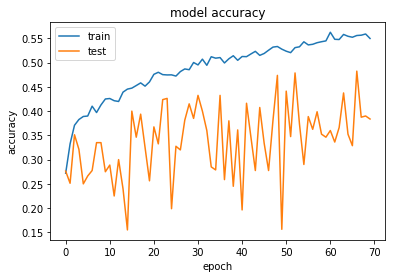

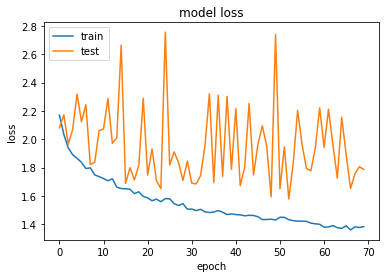

In [13]:
show_summary_stats(history)

In [27]:
from sklearn.metrics import classification_report

y_true = np.asarray(y_valid)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred,axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.63      0.12      0.20       100
 Experimental       0.22      0.71      0.33       100
         Folk       0.76      0.19      0.30       100
      Hip-Hop       0.46      0.77      0.57       100
 Instrumental       0.14      0.01      0.02       100
International       0.53      0.61      0.57       100
          Pop       0.11      0.04      0.06       100
         Rock       0.63      0.62      0.63       100

     accuracy                           0.38       800
    macro avg       0.43      0.38      0.33       800
 weighted avg       0.43      0.38      0.33       800



In [29]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.38375


### Connect to Test Set

In [30]:
from tensorflow.keras.models import load_model

weights_path = 'models/crnn/weights.best.h5'
model = load_model(weights_path)

In [31]:
npzfile = np.load('test_arr.npz')
print(npzfile.files)
X_test = npzfile['arr_0']
y_test = npzfile['arr_1']
print(X_test.shape, y_test.shape)

['arr_0', 'arr_1']
(800, 640, 128) (800,)


In [32]:
y_test -= 1
print(np.amin(y_test), np.amax(y_test), np.mean(y_test))

0 7 3.5


In [33]:
X_test_raw = librosa.core.db_to_power(X_test, ref=1.0)
print(np.amin(X_test_raw), np.amax(X_test_raw), np.mean(X_test_raw))

1e-08 1.0 0.004623813018385694


In [34]:
X_test = np.log(X_test_raw)


from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(800,) (800,)
               precision    recall  f1-score   support

   Electronic       0.64      0.49      0.55       100
 Experimental       0.28      0.22      0.25       100
         Folk       0.19      0.16      0.17       100
      Hip-Hop       0.57      0.85      0.68       100
 Instrumental       0.36      0.34      0.35       100
International       0.46      0.64      0.54       100
          Pop       0.30      0.27      0.28       100
         Rock       0.64      0.56      0.60       100

     accuracy                           0.44       800
    macro avg       0.43      0.44      0.43       800
 weighted avg       0.43      0.44      0.43       800



In [38]:
y_test = to_categorical(y_test, num_classes=8)
model.evaluate(X_test, y_test)

800/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[1.7413654232025146, 0.44125]

In [39]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_true, y_pred))

[[49  1  6 16  5 13  8  2]
 [ 9 22  8  9 21 17  7  7]
 [ 0 27 16  1 17 14 19  6]
 [ 3  2  1 85  1  6  2  0]
 [ 3 18 29  1 34  8  5  2]
 [ 3  1 10  9  3 64  6  4]
 [ 7  2  9 28  4 12 27 11]
 [ 3  6  4  1  9  4 17 56]]


In [40]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

0.44125


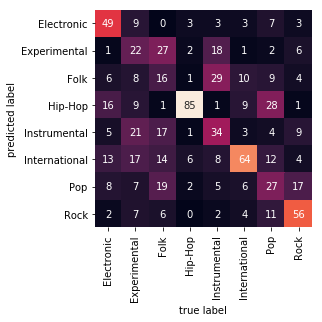

In [41]:
### 8 clusters
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');
